In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load both data files - this dataset requires a specific 'latin1' encoding
try:
    df1 = pd.read_csv('/kaggle/input/online-retail-ii-uci/year_2009-2010.csv', encoding='latin1')
    df2 = pd.read_csv('/kaggle/input/online-retail-ii-uci/year_2010-2011.csv', encoding='latin1')
    df = pd.concat([df1, df2])
except FileNotFoundError:
    # Some versions of the dataset have a single file
    df = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv', encoding='latin1')


print("--- Dataset loaded successfully! ---")
print(f"Original shape: {df.shape}")

# --- Initial Data Cleaning ---
# Drop rows with no Customer ID
df.dropna(subset=['Customer ID'], inplace=True)

# Convert Customer ID to integer
df['Customer ID'] = df['Customer ID'].astype(int)

# Keep only standard purchases (Invoice does not start with 'C' for cancelled)
df = df[~df['Invoice'].str.startswith('C', na=False)]

# Keep only transactions with a quantity greater than 0
df = df[df['Quantity'] > 0]

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Shape after cleaning: {df.shape}")
display(df.head())

--- Dataset loaded successfully! ---
Original shape: (1067371, 8)
Shape after cleaning: (805620, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [2]:
# Calculate TotalPrice for each transaction
df['TotalPrice'] = df['Quantity'] * df['Price']

# --- Calculate R, F, and M ---
# Set a snapshot date for analysis (one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by customer and calculate RFM values
df_rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

# Rename the columns for clarity
df_rfm.rename(columns={'InvoiceDate': 'Recency',
                       'Invoice': 'Frequency',
                       'TotalPrice': 'MonetaryValue'}, inplace=True)

print("--- RFM Features Calculated ---")
display(df_rfm.head())

--- RFM Features Calculated ---


,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,326,12,77556.46
12347,2,8,5633.32
12348,75,5,2019.40
12349,19,4,4428.69
12350,310,1,334.40


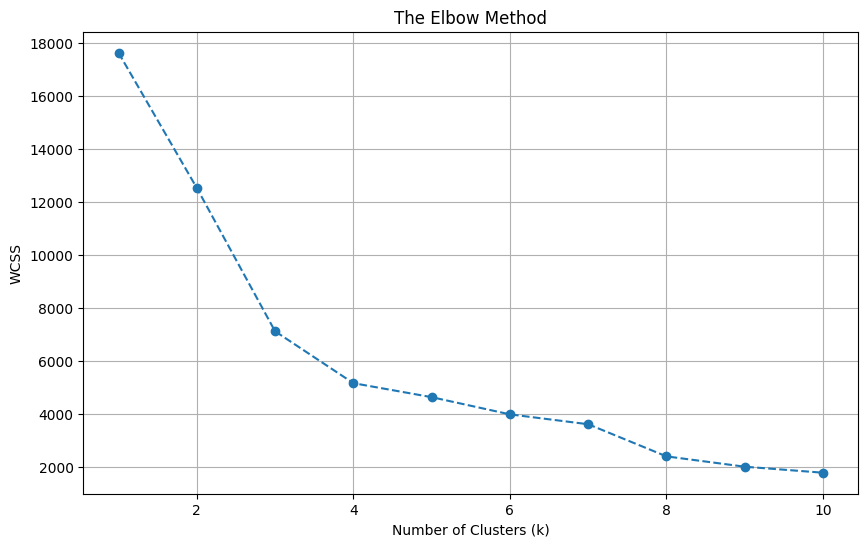

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Scale the data ---
# Clustering is sensitive to the scale of the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_rfm)

# --- Use the Elbow Method to find the best k ---
wcss = [] # Within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [4]:
from sklearn.cluster import KMeans

# Set k to the number you found from the elbow plot (e.g., 4)
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
df_rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the created segments by calculating the average RFM values for each
cluster_analysis = df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(2)

print("--- Analysis of Customer Segments ---")
display(cluster_analysis)

--- Analysis of Customer Segments ---


,Recency,Frequency,MonetaryValue
Cluster,,,
0,66.99,7.31,3008.62
1,463.23,2.21,764.48
2,3.50,212.75,436835.79
3,25.94,103.74,83086.08


In [5]:
from sklearn.model_selection import train_test_split

# Add the cluster labels back to our main RFM dataframe
df_rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Define churn: 1 if Recency > 180 days, 0 otherwise
churn_threshold = 180
df_rfm['is_churned'] = df_rfm['Recency'].apply(lambda x: 1 if x > churn_threshold else 0)

# Define features (X) and target (y)
X = df_rfm.drop(columns=['is_churned'])
y = df_rfm['is_churned']

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Churn data prepared:")
print(f"Number of churners in test set: {y_test.sum()} ({y_test.mean()*100:.2f}%)")
display(X_train.head())

Churn data prepared:
Number of churners in test set: 481 (40.87%)


,Recency,Frequency,MonetaryValue,Cluster
Customer ID,,,,
16513,5,4,874.59,0
15644,166,4,813.00,0
17017,3,29,14110.61,0
17100,18,2,971.74,0
13489,105,4,449.52,0


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
model_churn = LogisticRegression(random_state=42)
model_churn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_churn.predict(X_test)

# Evaluate the model
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Confusion Matrix ---
[[696   0]
 [  0 481]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      1.00      1.00       481

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# --- Prepare data for CLV ---
# We will predict the next 90 days of revenue
prediction_days = 90
max_date = df['InvoiceDate'].max()
split_point = max_date - dt.timedelta(days=prediction_days)

# Split data into historical (for features) and future (for target)
df_historical = df[df['InvoiceDate'] <= split_point]
df_future = df[df['InvoiceDate'] > split_point]

# --- Create Features from Historical Data ---
snapshot_date_hist = df_historical['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by customer and calculate RFM values from the historical period
df_clv_features = df_historical.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (snapshot_date_hist - date.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
df_clv_features.rename(columns={'InvoiceDate': 'Recency',
                                'Invoice': 'Frequency',
                                'TotalPrice': 'MonetaryValue'}, inplace=True)

# --- Create Target from Future Data ---
df_clv_target = df_future.groupby('Customer ID')['TotalPrice'].sum().reset_index()
df_clv_target.rename(columns={'TotalPrice': 'FutureRevenue'}, inplace=True)

# --- Merge Features and Target ---
df_clv = pd.merge(df_clv_features, df_clv_target, on='Customer ID', how='left')
# Customers who didn't buy in the future have 0 revenue
df_clv['FutureRevenue'] = df_clv['FutureRevenue'].fillna(0)

print("--- Data for CLV Prediction Prepared ---")
display(df_clv.head())

--- Data for CLV Prediction Prepared ---


,Customer ID,Recency,Frequency,MonetaryValue,FutureRevenue
0,12346,235,12,77556.46,0.00
1,12347,39,6,4114.18,1519.14
2,12348,158,4,1709.40,310.00
3,12349,317,3,2671.14,1757.55
4,12350,219,1,334.40,0.00


In [8]:
# Define features (X) and target (y)
X_clv = df_clv[['Recency', 'Frequency', 'MonetaryValue']]
y_clv = df_clv['FutureRevenue']

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_clv, y_clv, test_size=0.2, random_state=42)

# Initialize and train the model
model_clv = RandomForestRegressor(random_state=42, n_jobs=-1)
model_clv.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_clv.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("--- CLV Model Performance ---")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")

--- CLV Model Performance ---
R-squared (R²) Score: 0.1931
Mean Absolute Error (MAE): $479.44


In [9]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 57.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [11]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import datetime as dt

# --- 1. Filter for a recent and manageable subset of data ---
# This is the key step to prevent memory errors
max_date = df['InvoiceDate'].max()
start_date = max_date - pd.DateOffset(months=6)
df_recent = df[df['InvoiceDate'] >= start_date].copy()
df_uk = df_recent[df_recent['Country'] == 'United Kingdom'].copy()

# --- 2. Filter for reasonably popular products ---
product_counts = df_uk['Description'].value_counts()
popular_products = product_counts[product_counts >= 20].index
df_filtered = df_uk[df_uk['Description'].isin(popular_products)]


# --- 3. Use the memory-efficient TransactionEncoder method ---
# Create a list of transactions (baskets) by Invoice
basket = df_filtered.groupby('Invoice')['Description'].apply(list).tolist()

# Encode the transaction list into a boolean matrix
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)


# --- 4. Build the Association Rules Model ---
# Find itemsets with at least 3% support in recent data
frequent_itemsets = apriori(df_trans, min_support=0.03, use_colnames=True)

# Generate the final "if-then" rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print("--- Product Recommendation Rules Generated ---")
display(rules.head())

--- Product Recommendation Rules Generated ---


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.044918,0.048714,0.031210,0.694836,14.263683,1.0,0.029022,3.117292,0.973625,0.500000,0.679209,0.667764
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.048714,0.044918,0.031210,0.640693,14.263683,1.0,0.029022,2.658120,0.977510,0.500000,0.623794,0.667764
2,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.068642,0.057360,0.041649,0.606759,10.578126,1.0,0.037712,2.397105,0.972199,0.493750,0.582830,0.666431
3,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.057360,0.068642,0.041649,0.726103,10.578126,1.0,0.037712,3.400395,0.960563,0.493750,0.705916,0.666431
4,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.049557,0.091523,0.031105,0.627660,6.857976,1.0,0.026569,2.439911,0.898723,0.282838,0.590149,0.483761


In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# --- Create the Main Tab Widget ---
# We will have three tabs, with Churn and CLV combined as they use the same inputs
tab = widgets.Tab()

# ==============================================================================
# --- TAB 1: CUSTOMER SEGMENTATION EXPLORER ---
# ==============================================================================

# Create widgets for Tab 1
cluster_names = {
    0: "New / Casual Customers",
    1: "Lost / Churned Customers",
    2: "Champions / Best Customers",
    3: "Loyal Customers"
}
segment_dropdown = widgets.Dropdown(options=[(v, k) for k, v in cluster_names.items()], description='View Segment:')
segment_output = widgets.Output()

# Function to display segment info
def view_segment(change):
    with segment_output:
        clear_output(wait=True)
        cluster_num = change.new
        print(f"--- Characteristics of '{cluster_names[cluster_num]}' ---")
        display(cluster_analysis.loc[cluster_num].to_frame().T)
        
segment_dropdown.observe(view_segment, names='value')
# VBox holds the widgets for this tab
tab1 = widgets.VBox([segment_dropdown, segment_output])


# ==============================================================================
# --- TAB 2: CHURN & CLV PREDICTOR ---
# ==============================================================================

# Create widgets for Tab 2
recency_slider = widgets.IntSlider(value=50, min=1, max=700, description='Recency (Days):', style={'description_width': 'initial'})
freq_slider = widgets.IntSlider(value=20, min=1, max=250, description='Frequency (Purchases):', style={'description_width': 'initial'})
money_slider = widgets.FloatSlider(value=3000, min=100, max=50000, step=100, description='Monetary Value ($):', style={'description_width': 'initial'})
cluster_dropdown_pred = widgets.Dropdown(options=[(v, k) for k, v in cluster_names.items()], description='Assigned Segment:', style={'description_width': 'initial'})
predict_button = widgets.Button(description="Calculate Predictions", button_style='success')
predictor_output = widgets.Output()

# Function to make predictions
def make_predictions(b):
    with predictor_output:
        clear_output(wait=True)
        input_data_churn = pd.DataFrame({
            'Recency': [recency_slider.value], 'Frequency': [freq_slider.value],
            'MonetaryValue': [money_slider.value], 'Cluster': [cluster_dropdown_pred.value]
        })
        input_data_clv = input_data_churn[['Recency', 'Frequency', 'MonetaryValue']]
        
        # Predict Churn
        churn_prob = model_churn.predict_proba(input_data_churn)[:, 1]
        print("--- Churn Prediction ---")
        print(f"Probability of Churn: {churn_prob[0]:.2%}")

        # Predict CLV
        clv_pred = model_clv.predict(input_data_clv)
        print(f"\n--- CLV Prediction ---")
        print(f"Predicted 90-Day Revenue: ${clv_pred[0]:.2f}")
        
predict_button.on_click(make_predictions)
# VBox holds the widgets for this tab
tab2 = widgets.VBox([recency_slider, freq_slider, money_slider, cluster_dropdown_pred, predict_button, predictor_output])


# ==============================================================================
# --- TAB 3: PRODUCT RECOMMENDER ---
# ==============================================================================

# Get a list of popular items for the dropdown
popular_items = list(rules['antecedents'].astype(str).unique())
product_dropdown = widgets.Dropdown(options=popular_items, description='If a user buys:')
reco_output = widgets.Output()

# Function to get recommendations
def get_recommendations(change):
    with reco_output:
        clear_output(wait=True)
        # The item is stored as a frozenset, so we need to convert the string back
        selected_item = eval(change.new) 
        recommendations = rules[rules['antecedents'] == selected_item].sort_values(by='lift', ascending=False)
        
        if recommendations.empty:
            print("No specific recommendations found for this item.")
        else:
            print(f"--- Customers who buy this also frequently buy: ---")
            # Convert frozenset to a more readable list
            reco_list = [list(item) for item in recommendations['consequents']]
            for item in reco_list[:5]: # Show top 5
                print(f"- {item[0]}")

product_dropdown.observe(get_recommendations, names='value')
# VBox holds the widgets for this tab
tab3 = widgets.VBox([product_dropdown, reco_output])


# ==============================================================================
# --- FINAL ASSEMBLY ---
# ==============================================================================
tab.children = [tab1, tab2, tab3]
tab.set_title(0, '1. Customer Segments')
tab.set_title(1, '2. Churn & CLV Prediction')
tab.set_title(2, '3. Product Recommender')

display(tab)

In [13]:
import joblib

# Save the K-Means clustering model
joblib.dump(kmeans, 'kmeans_segmentation_model.joblib')

# Save the Churn prediction model
joblib.dump(model_churn, 'churn_prediction_model.joblib')

# Save the CLV prediction model
joblib.dump(model_clv, 'clv_prediction_model.joblib')

# Save the product recommendation rules
rules.to_csv('product_recommendation_rules.csv', index=False)

print("All models and rules saved successfully.")

All models and rules saved successfully.
